<a href="https://colab.research.google.com/github/Snafkin547/Drive-Assistant/blob/main/Drive_Assistant_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1.Load Necessary packages

In [ ]:
import keras
import keras.utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Layer, Concatenate, BatchNormalization
from keras.layers.convolutional import Conv2D,MaxPooling2D,AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
import tensorflow as tf
from keras.initializers import Initializer
from keras import regularizers
from keras import backend as K
from google.colab import drive

import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.optimizers import SGD
from keras.initializers import Constant
from keras.preprocessing.image import ImageDataGenerator


### 2.Import Data and Preprocessing Pipeline

In [ ]:
#Google Drive mounting to Google Colab
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/CS767 Machine Learning/Kaggle"
#Change the working directory
%cd /content/gdrive/My Drive/CS767 Machine Learning/Kaggle

Mounted at /content/gdrive
/content/gdrive/My Drive/CS767 Machine Learning/Kaggle


In [ ]:
#Define the root directory where the data is saved
base_dir='/content/gdrive/MyDrive/CS767 Machine Learning/Kaggle/Dataset 1 (Simplex)/Dataset 1 (Simplex)'
train_dir=os.path.join(base_dir, 'Train data')

In [ ]:
target_size=(276,368)
batch_size = 8
epochs=10

In [ ]:
#Generate train & test dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                   fill_mode='nearest',        
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)


# The list of classes will be automatically inferred from the subdirectory names/structure under train_dir
train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size=target_size,
                  batch_size=batch_size,
                  class_mode='binary',
                  subset='training')

validation_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=target_size,
                       batch_size=batch_size,
                       class_mode='binary',
                       subset='validation')


Found 3023 images belonging to 2 classes.
Found 754 images belonging to 2 classes.


In [ ]:
## Create a hdf5 file for Training data
training_data_n = len(train_generator.filenames)
training_class_n=len(train_generator.class_indices)

if os.path.exists('./train_b.h5')!=True:
  f = h5py.File("./train_b.h5", 'w')

train_x = f.create_dataset('training_x', (training_data_n,target_size[0],target_size[1],3), dtype='f')
train_y = f.create_dataset('training_y', (training_data_n,1), dtype=np.int64)

cnt=0
for x_batch, y_batch in train_generator:
  for i in range(batch_size):
    train_x[cnt] = x_batch[i]
    train_y[cnt] = y_batch[i]
    cnt = cnt+1
    if cnt>=training_data_n:
        break
  if cnt>=training_data_n:
    break
f.close()

## Create a hdf5 file for Validation data 
validation_data_n = len(validation_generator.filenames)
validation_class_n=len(validation_generator.class_indices)

if os.path.exists('validation_b.h5')!=True:
  f = h5py.File("./validation_b.h5", 'w')

validation_x = f.create_dataset('validation_x', (validation_data_n,target_size[0],target_size[1],3), dtype='f')
validation_y = f.create_dataset('validation_y', (validation_data_n,1), dtype=np.int64)

cnt=0
for x_batch, y_batch in validation_generator:
  for i in range(batch_size):
    validation_x[cnt] = x_batch[i]
    validation_y[cnt] = y_batch[i]
    cnt = cnt+1
    if cnt>=validation_data_n:
        break
  if cnt>=validation_data_n:
    break
f.close()

In [ ]:
#Load Saved hdf5 file
f = h5py.File('./train.h5', 'r')
tx = f['training_x'][...]
ty = f['training_y'][...]
f.close()

f = h5py.File('./validation.h5', 'r')
vx = f['validation_x'][...]
vy = f['validation_y'][...]
f.close()

tx = tx.reshape((len(tx), target_size[0], target_size[1], 3))
vx  = vx.reshape((len(vx), target_size[0], target_size[1], 3))

### 3.Define Functions

In [ ]:
def result(history, name):
  print("Model Name:" + name)
  #Bold face print('\033[1m'+"Model Name:" + name)
  acc=history.history['val_accuracy']
  loss = history.history['val_loss']
  print("Accuracy of the Model: {}% \n Error: {}".format(acc[-1]*100, loss[-1]))
  
  fig = plt.figure(figsize=(12, 6))
  ax=fig.add_subplot(121)
  ax2=fig.add_subplot(122)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  ax.plot(epochs, loss, 'y', label='Training loss')
  ax.plot(epochs, val_loss, 'r', label='Validation loss')
  ax.set_title('Training and validation loss')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.legend()
  ax.set_ylim([0, 1])

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(accuracy) + 1)
  ax2.plot(epochs, accuracy, 'y', label='Training accuracy')
  ax2.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
  ax2.set_title('Training and validation accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('accuracy')
  ax2.legend()
  ax2.set_ylim([0, 1])
  plt.show()


def confusion(model, test_x, test_y):
  y_pred=model.predict(test_x)
  seq_predictions=np.transpose(y_pred)[0]  # transformation to get (n,)
  seq_predictions = list(map(lambda x: 0 if x<0.5 else 1, seq_predictions))
  cmx = confusion_matrix(test_y,seq_predictions)
  sns.heatmap(cmx, annot=True, fmt='g', square=True)
  plt.show()
  TruePositive = np.diag(cmx)
  FalsePositive = []
  for i in range(1):
    FalsePositive.append(sum(cmx[:,i]) - cmx[i,i])

  FalseNegative = []
  for i in range(1):
      FalseNegative.append(sum(cmx[i,:]) - cmx[i,i])
  
  print("False Negative rate: ", 1 - FalseNegative[0]/(FalsePositive[0]+FalseNegative[0]))
  return cmx

def run_model(model, name, train_x, train_y, validation_data, epochs=epochs):
  history=model.fit(x=train_x, y=train_y, validation_data=validation_data, epochs=epochs, verbose=1, shuffle=True, steps_per_epoch = len(train_x)/epochs)
  result(history, name)
  confusion(model, validation_data[0],validation_data[1])
  return history, model

def signals(model, input):
  pixels = np.expand_dims(input, axis=0)
  y_pred=model.predict(pixels)
  y_pred=np.transpose(y_pred)[0]
  signal="Stop" if y_pred>0.5 else "Keep going"
  print(signal)


### 4.Define Inception Layer

In [ ]:
class inception(Layer):
  def __init__(self,
               filters_1x1,
               filters_3x3_reduce,
               filters_3x3,
               filters_5x5_reduce,
               filters_5x5,
               filters_pool_proj, 
               activation, 
               kernel_initializer,
               kernel_regularizer,
               **kwargs):
    super(inception, self).__init__(**kwargs)
    self.conv_1x1=Conv2D(filters_1x1, kernel_size=(1,1), strides=(1,1), padding="same", activation=activation, kernel_initializer=initializer,kernel_regularizer=regularizer)

    self.conv_3x3_1=Conv2D(filters_3x3_reduce, kernel_size=(1,1), strides=(1,1), padding="same", activation=activation, kernel_initializer=initializer,kernel_regularizer=regularizer)
    self.conv_3x3_2=Conv2D(filters_3x3, kernel_size=(3,3), strides=(1,1), padding="same", activation=activation, kernel_initializer=initializer,kernel_regularizer=regularizer)

    self.conv_5x5_1=Conv2D(filters_5x5_reduce, kernel_size=(1,1), strides=(1,1), padding="same", activation=activation, kernel_initializer=initializer,kernel_regularizer=regularizer)
    self.conv_5x5_2=Conv2D(filters_5x5, kernel_size=(5,5), strides=(1,1), padding="same", activation=activation, kernel_initializer=initializer,kernel_regularizer=regularizer)

    self.mx_pool_1=MaxPooling2D(pool_size=(3,3), strides=(1,1),padding="same")
    self.mx_pool_2=Conv2D(filters_pool_proj, kernel_size=(1,1), strides=(1,1),padding="same", activation=activation, kernel_initializer=initializer,kernel_regularizer=regularizer)

  def forward(self):
    return Concatenate([self.conv_1x1, self.conv_3x3_1(self.conv_3x3_2), self.conv_5x5_1(self.conv_5x5_2), self.mx_pool_1(self.mx_pool_2)], axis=3)


### 5.Model


Epoch 1/11
274/274 [==============================] - 26s 84ms/step - loss: 0.9827 - accuracy: 0.6110 - val_loss: 0.6579 - val_accuracy: 0.7042
Epoch 2/11
274/274 [==============================] - 22s 82ms/step - loss: 0.7340 - accuracy: 0.6443 - val_loss: 0.6180 - val_accuracy: 0.7042
Epoch 3/11
274/274 [==============================] - 22s 81ms/step - loss: 0.6967 - accuracy: 0.6426 - val_loss: 0.6070 - val_accuracy: 0.7255
Epoch 4/11
274/274 [==============================] - 22s 82ms/step - loss: 0.6215 - accuracy: 0.7132 - val_loss: 0.5154 - val_accuracy: 0.7851
Epoch 5/11
274/274 [==============================] - 22s 81ms/step - loss: 0.5088 - accuracy: 0.7859 - val_loss: 0.4107 - val_accuracy: 0.8515
Epoch 6/11
274/274 [==============================] - 22s 82ms/step - loss: 0.4840 - accuracy: 0.8026 - val_loss: 0.4442 - val_accuracy: 0.8289
Epoch 7/11
274/274 [==============================] - 22s 82ms/step - loss: 0.4284 - accuracy: 0.8271 - val_loss: 0.3950 - val_accuracy:

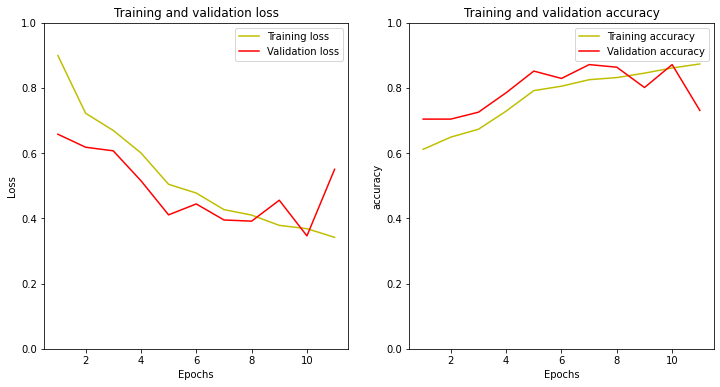

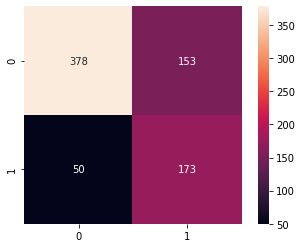

False Negative rate:  0.24630541871921185


In [ ]:
Name= "154'_more features(150)_Three_Fully_SeLUFul_addMaxP(3)_MoreDO(3)_inceptionmodified_L1_LR sched"

def GoogLeNet(opt, af, initializer, regularizers):
  model=Sequential()
  model.add(Conv2D(filters=150, kernel_size=(7,7), strides=(2,2), padding="same", activation=af, kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),padding="same"))
  model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=2, bias=1, alpha=0.00002, beta=0.75, name=None)))
  model.add(Conv2D(filters=150, kernel_size=(1,1), strides=(1,1), padding="same", activation=af,kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),padding="same")) #
  model.add(Conv2D(filters=192, kernel_size=(3,3), strides=(1,1), padding="same", activation=af,kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=2, bias=1, alpha=0.00002, beta=0.75, name=None)))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),padding="same"))
  model.add(inception(filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32, 
                      activation=af, kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),padding="same")) #
  model.add(inception(filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64, 
                      activation=af, kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),padding="same"))
  model.add(inception(filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64, 
                      activation=af, kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),padding="same")) #
  model.add(inception(filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64, 
                      activation=af, kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(inception(filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64, 
                      activation=af, kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(inception(filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool_proj=64, 
                      activation=af, kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(inception(filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, 
                      activation=af, kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),padding="same"))
  model.add(inception(filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, 
                      activation=af, kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(inception(filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128, 
                      activation=af, kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1000, activation=af, kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(Dropout(0.4))
  model.add(Dense(100, activation=af, kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(Dropout(0.4))
  model.add(Dense(100, activation=af, kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer, kernel_regularizer=regularizer))
  model.compile(optimizer=opt, loss='binary_crossentropy',  metrics=['accuracy'])
  return model

af='selu'
initializer="lecun_normal"
regularizer=regularizers.l2(l2=1e-5)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.001,
  decay_steps=len(tx)/epochs,
  decay_rate=0.95)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

history, model=run_model(GoogLeNet(opt, af, initializer, regularizers), name=Name, train_x=tx, train_y=ty, validation_data=(vx, vy), epochs=11)

### 6.Signal Function

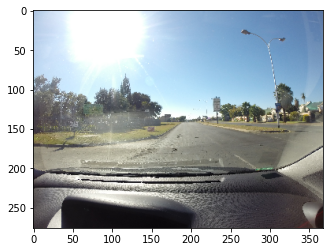

Stop


In [ ]:
# Stop Signal when potholes are present
input=vx[52]
plt.figure()
plt.imshow(input) 
plt.show()
signals(model, input)


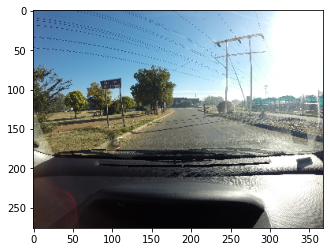

Keep going


In [ ]:
input=vx[10]

plt.figure()
plt.imshow(input) 
plt.show()
signals(model, input)
